# Run calibration 1.4.2 with May's five scenarios

Run annually with UKESM1-0-LL calibration of fair.

- 5 scenarios from May's GRL paper with the 1000 member ensemble from v1.4.2 (1000 x 5)
  - 65 (2.5th percentile)
  - 204 (50.0th percentile)
  - 824 (50.5th percentile)
  - 466 (97.5th percentile)
  - 364 (98.0th percentile)
- Run all above with the average forcing from each ensemble member (+ 1000 x 5)

In [1]:
import os

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import pooch
import xarray as xr
from tqdm.auto import tqdm

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

In [2]:
scenarios = ["ssp370"]

In [3]:
df_solar = pd.read_csv(
    "../data/fair2.1-parameters/ukesm/natural_forcing.csv", index_col=0
)
df_volcanic_hist = pd.read_csv(
    "../data/volcanic-forcing/yearly/forcing_yearly_cmip6_1850-2014.csv", index_col=0
)

In [4]:
climate_response_df = pd.read_csv('../data/fair2.1-parameters/ukesm/4xCO2_energy_balance_ebm3.csv')

In [5]:
df_solar['solar']

1850    0.000000
1851   -0.012730
1852   -0.019931
1853   -0.020958
1854   -0.034266
          ...   
2296   -0.028256
2297    0.002412
2298    0.035358
2299    0.036211
2300    0.011096
Name: solar, Length: 451, dtype: float64

UKESM calibration of fair

ERF = -19.742 SAOD + 0.31227

In [6]:
df_yearly_scen = pd.read_csv(
    f"../data/volcanic-forcing/yearly/forcing_yearly_scen1.csv", index_col=0
)
df_yearly_scen

,Global yearly mean SAOD at 550nm,Global yearly mean TOA ERF (W/m2)
Time (year),,
2015,0.003637,-0.019482
2016,0.004091,-0.028884
2017,0.004631,-0.040027
2018,0.010246,-0.155725
2019,0.058829,-1.129954
...,...,...
2096,0.007563,-0.100525
2097,0.006349,-0.075507
2098,0.005069,-0.049086


In [7]:
volcanic_forcing = np.zeros((352, 1, 5))
solar_forcing = np.zeros((352))
solar_forcing[100:] = df_solar['solar'].loc[1850:2101].values.squeeze()

for ivolc, volcanic_config in tqdm(enumerate([65, 204, 824, 466, 364])):
    df_yearly_scen = pd.read_csv(
        f"../data/volcanic-forcing/yearly/forcing_yearly_scen{volcanic_config}.csv", index_col=0
    )
    volcanic_future = df_yearly_scen['Global yearly mean TOA ERF (W/m2)']
    volcanic_forcing[:101, 0, ivolc] = 0
    volcanic_forcing[101:266, 0, ivolc] = -19.742 * (
        df_volcanic_hist['Global yearly mean SAOD at 550nm']
    ).to_numpy() + 0.31227
    volcanic_forcing[266:, 0, ivolc] = -19.742 * (
        df_yearly_scen['Global yearly mean SAOD at 550nm']
    ).to_numpy() + 0.31227

f = FAIR(ch4_method="Thornhill2021")
f.define_time(1750, 2101, 1)
f.define_scenarios(scenarios)
f.define_configs([65, 204, 824, 466, 364])
species, properties = read_properties()
species.remove('CO2 FFI')      # c-driven run
species.remove("Halon-1202")
species.remove("NOx aviation")
species.remove("Contrails")
species.remove('Light absorbing particles on snow and ice')  # I believe not modelled in UKESM
del properties['CO2 FFI']
#del properties['CO2 AFOLU']
del properties['Halon-1202']
del properties['Contrails']
del properties['NOx aviation']
del properties['Light absorbing particles on snow and ice']

for specie in species:
    if properties[specie]['greenhouse_gas']:
        properties[specie]['input_mode'] = 'concentration'
        
f.define_species(species, properties)
f.allocate()
    
f.fill_from_rcmip()
    
# climate response
fill(f.climate_configs['ocean_heat_capacity'], climate_response_df.loc[0, 'C1':'C3'])
fill(f.climate_configs['ocean_heat_transfer'], climate_response_df.loc[0, 'kappa1':'kappa3'])
fill(f.climate_configs['deep_ocean_efficacy'], climate_response_df.loc[0, 'epsilon'])
fill(f.climate_configs['gamma_autocorrelation'], climate_response_df.loc[0, 'gamma'])
        
# species level
f.fill_species_configs()
    
# 1850 baselines
for specie in ['Sulfur', 'BC', 'OC', 'NOx', 'VOC', 'CO', 'NH3']:
    f.species_configs['baseline_emissions'].loc[dict(specie=specie)] = f.emissions.loc[
        dict(specie=specie, timepoints=1850.5, scenario='ssp370')
    ]

for specie in ['CO2', 'CH4', 'N2O', 'CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b',
    'CCl4', 'CHCl3', 'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301', 'Halon-2402',
    'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2',
    'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
    'HFC-32', 'HFC-365mfc', 'HFC-4310mee']:
    f.species_configs['baseline_concentration'].loc[dict(specie=specie)] = f.concentration.loc[
        dict(specie=specie, timebounds=1850, scenario='ssp370')
    ]

f.species_configs['baseline_concentration'].loc[dict(specie='Equivalent effective stratospheric chlorine')] = 344.36275911

ods = ['CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b',
    'CCl4', 'CHCl3', 'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301', 'Halon-2402']

hfc = ['CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2',
    'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa', 'HFC-32',
    'HFC-365mfc', 'HFC-4310mee']

# UKESM specific ESM component calibrations: DO NOT MODIFY
f.species_configs['land_use_cumulative_emissions_to_forcing'].loc[dict(specie="CO2 AFOLU")] = 0.0003024895261521421
f.species_configs['forcing_scale'].loc[dict(specie="CH4")] = 1.11547955
f.species_configs['h2o_stratospheric_factor'].loc[dict(specie="CH4")] = 1.29652705e-01
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="CH4")] = 1.27049657e-04
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="Equivalent effective stratospheric chlorine")] = -0.00029119797470220245
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="N2O")] = 0.0007481397748679878
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="VOC")] = 0.0006596999582126578
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="NOx")] = 0.000984642055228785
f.species_configs['forcing_temperature_feedback'].loc[dict(specie="Ozone")] = -0.079
f.species_configs['forcing_scale'].loc[dict(specie="N2O")] = 1.0845323023219764
f.species_configs['forcing_scale'].loc[dict(specie="CO2")] = 0.9935419214400296
    
for specie in species:
    f.species_configs['erfari_radiative_efficiency'].loc[dict(specie=specie)] = 0
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='Sulfur')] = -0.00283793
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='BC')] = 0.01757433
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='OC')] = -0.0028512
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='CH4')] = -5.09377882e-05
f.species_configs['aci_scale'].loc[:] = -8.22336280e-01
f.species_configs['aci_shape'].loc[dict(specie='Sulfur')] = 3.01888722e-02
f.species_configs['aci_shape'].loc[dict(specie='BC')] = 5.07111186e-30
f.species_configs['aci_shape'].loc[dict(specie='OC')] = 6.60381587e-16
f.species_configs['aci_shape'].loc[dict(specie="CH4")] = -2.61186114e-04
    
for specie in ods:
    f.species_configs['forcing_scale'].loc[dict(specie=specie)] = 1.33139609
for specie in hfc:
    f.species_configs['forcing_scale'].loc[dict(specie=specie)] = 0.25250486

# solar and volcanic forcing
fill(
    f.forcing,
    volcanic_forcing,
    specie="Volcanic",
)

fill(
    f.forcing,
    solar_forcing[:, None, None],
    specie="Solar",
)

# initial conditions
initialise(f.forcing, 0)
initialise(f.temperature, 0)
    
f.run(progress=False)
    
weights = np.zeros((352, 1, 5))
weights[100, :, :] = 0.5
weights[101:151, :, :] = 1
weights[151, :, :] = 0.5
weights = xr.DataArray(
    weights, 
    dims=f.temperature.sel(layer=0).dims, 
    coords=f.temperature.sel(layer=0).coords
)
    
output = (
    f.temperature.sel(layer=0) - f.temperature.sel(layer=0).weighted(weights).mean(dim="timebounds")
).sel(scenario='ssp370', timebounds=np.arange(1850, 2102))

0it [00:00, ?it/s]

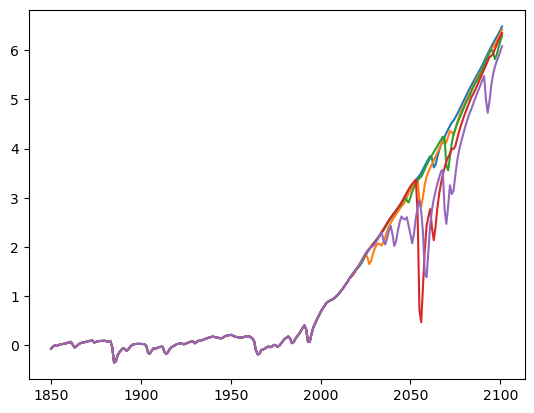

In [8]:
pl.plot(
    f.timebounds[100:],
    output
);

In [9]:
# SAVE OUT OUTPUT
os.makedirs('../output', exist_ok=True)

In [10]:
ds = xr.Dataset(
    data_vars = dict(
        temperature = (["timebounds", "volcanic_forcing"], output.data),
    ),
    coords = dict(
        timebounds = np.arange(1850, 2102),
        volcanic_forcing = [65, 204, 824, 466, 364],
    ),
)

In [11]:
ds.to_netcdf('../output/ukesm_calibration_five_scenarios.nc')